# Objective: 
The goal of the project is to create a classifier capable of determining a plant's species from a photo.

## Context: 
You are provided with a dataset of images of plant seedlings at various stages of grown. Each image has a filename that is its unique id. The dataset comprises 12 plant species. Can you differentiate a weed from a crop seedling? The ability to do so effectively can mean better crop yields and better stewardship of the environment.

## Load dataset and Summary

#### Import libraries

In [1]:
#conda install -c conda-forge opencv
#conda install tensorflow-probability

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Basic libraries
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

# Tensorflow
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.layers import Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras

# Display
from IPython.display import Image
import matplotlib.cm as cm

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# For confusion matrix 
import seaborn as sns
sns.set_style('darkgrid')

#### Load dataset & print shape

In [4]:
# Import data into pandas dataframe, 4750 records of labels
labels = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Labels.csv')
labels.shape

(4750, 1)

In [5]:
# Check for NULL values, which there are none
labels['Label'].isnull().values.any()

False

In [6]:
# Show number of plant species, which is 12
labels['Label'].nunique()

12

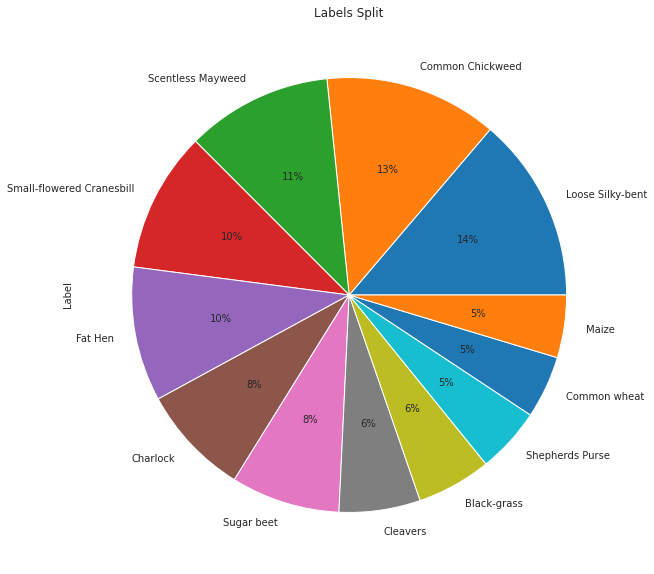

In [7]:
# Show distribution of 12 label classes in a Pie Chart
labels['Label'].value_counts(ascending=False).plot(kind='pie',autopct='%1.0f%%',figsize=(10, 10), title='Labels Split')

In [8]:
# Read data into numpy array, shape matches Labels dataframe 
# with a shape of 4750 images of 128x128 pixels with depth of 3 each
data_raw = np.load('/content/drive/MyDrive/Colab Notebooks/images.npy')
data_raw.shape

(4750, 128, 128, 3)

#### Visualise Images in dataset

1 . Label: Small-flowered Cranesbill, image # 0
2 . Label: Fat Hen, image # 496
3 . Label: Shepherds Purse, image # 971
4 . Label: Common wheat, image # 1202
5 . Label: Common Chickweed, image # 1423
6 . Label: Charlock, image # 2034
7 . Label: Cleavers, image # 2424
8 . Label: Scentless Mayweed, image # 2711
9 . Label: Sugar beet, image # 3227
10 . Label: Maize, image # 3612
11 . Label: Black-grass, image # 3833
12 . Label: Loose Silky-bent, image # 4096


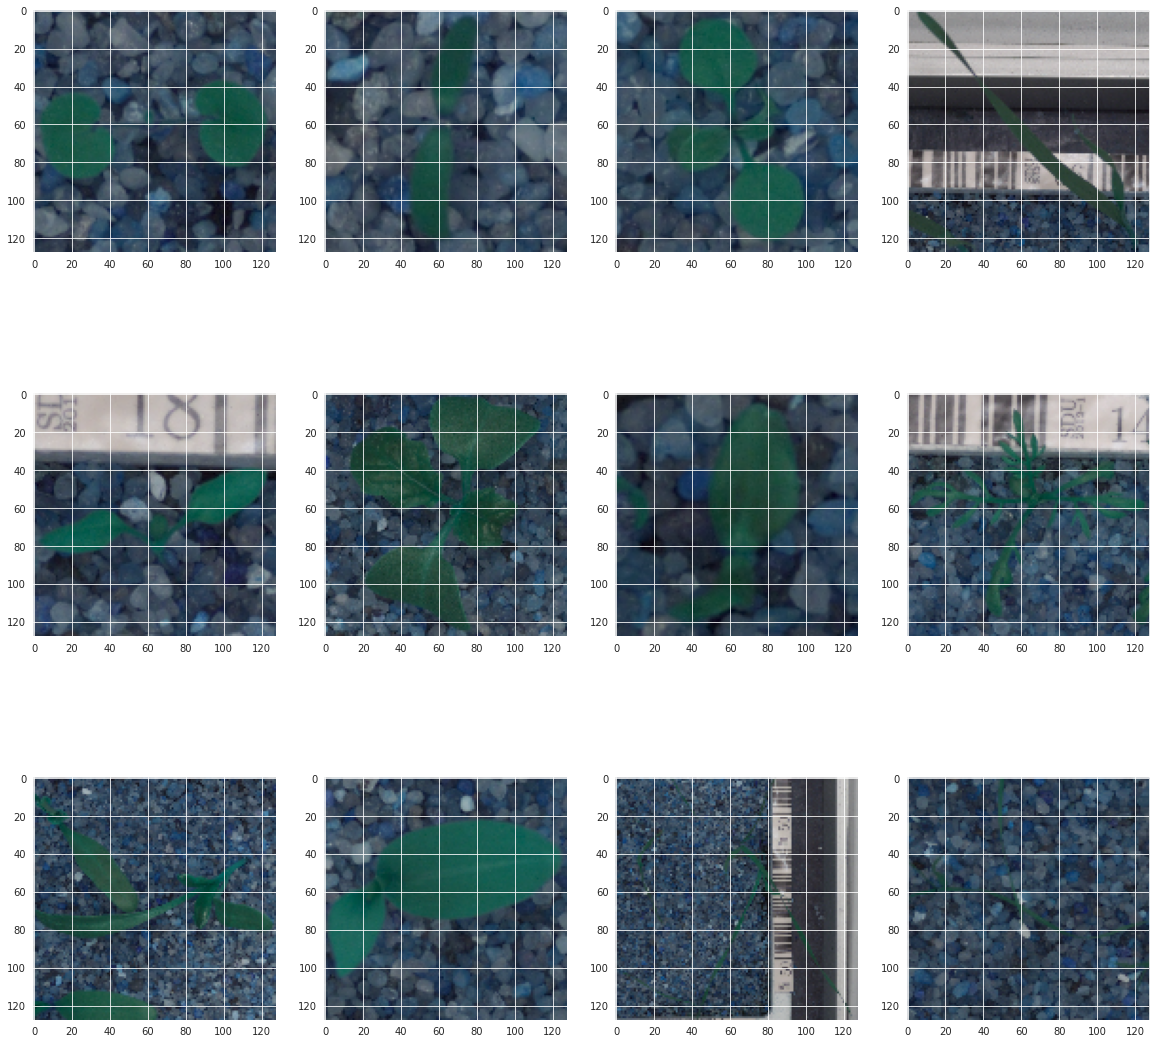

In [9]:
# Show 1 image each of the 12 classes
plt.figure(figsize=(20, 20))
p = 1

for i in labels.Label.unique():
    for j in range(data_raw.shape[0]):
        if labels['Label'][j] == i:
            print(p, '. Label: {}, image # {}'.format(labels['Label'][j], j))
            plt.subplot(3, 4, p)
            plt.imshow(data_raw[j, :, :, :]);
            p += 1
            break

## Data Pre - Processing

#### Normalization

In [10]:
# Create a copy of the data to work on
data = data_raw.copy()

In [11]:
# Print 1st image's 1st pixel RGB before converting to float and normalizing
data[0, 0, 0, :]

array([35, 52, 78], dtype=uint8)

In [12]:
# Ensure float type for the data, before normalization
data = data.astype('float32') 

In [13]:
# Normalise the data
data /= 255.0

In [14]:
# Print 1st image's 1st pixel RGB after converting to float and normalizing
data[0, 0, 0, :]

array([0.13725491, 0.20392157, 0.30588236], dtype=float32)

#### Gaussian Blurring

In [15]:
# Create an empty numpy array for Gaussian Blurred Images, with same shape as original image array
data_blur = np.empty(data.shape)

In [16]:
data_blur.shape

(4750, 128, 128, 3)

In [17]:
# Apply 5x5 gaussian blur to each 128x128x3 pixels image to reduce the noise in the image
for idx, img in enumerate(data):
    data_blur[idx] = cv2.GaussianBlur(img, (5, 5), 0)

Compare "data_blur" 1st image array values with "data" 1st image to confirm blurring
- data_blur[0,:,:,:] = [0.14289217, 0.19889706, 0.28982845]
- data[0,:,:,:] = [0.13725491, 0.20392157, 0.30588236]

In [18]:
data_blur[0,:,:,:]

array([[[0.14289217, 0.19889706, 0.28982845],
        [0.15450369, 0.2114277 , 0.29889706],
        [0.18792893, 0.24690564, 0.32536766],
        ...,
        [0.30664828, 0.36755514, 0.4327206 ],
        [0.3068321 , 0.36623776, 0.42873773],
        [0.30674022, 0.36513484, 0.42573529]],

       [[0.14503677, 0.20321693, 0.28988972],
        [0.16072306, 0.21960786, 0.3030178 ],
        [0.20130208, 0.2617341 , 0.33688727],
        ...,
        [0.30807292, 0.36749387, 0.43051472],
        [0.30848652, 0.36700368, 0.42732844],
        [0.30827206, 0.36617649, 0.42469361]],

       [[0.14886643, 0.21274512, 0.29252452],
        [0.17101717, 0.23477329, 0.31173408],
        [0.222932  , 0.28633583, 0.35652575],
        ...,
        [0.30916056, 0.36587009, 0.42458639],
        [0.31130517, 0.3681066 , 0.42398897],
        [0.31161153, 0.36853558, 0.42261031]],

       ...,

       [[0.15257353, 0.21063113, 0.27999389],
        [0.15632659, 0.21415442, 0.28201595],
        [0.16456802, 0

In [19]:
data[0,:,:,:]

array([[[0.13725491, 0.20392157, 0.30588236],
        [0.14117648, 0.19215687, 0.29803923],
        [0.12156863, 0.1764706 , 0.27058825],
        ...,
        [0.30588236, 0.37254903, 0.44705883],
        [0.29803923, 0.3647059 , 0.43137255],
        [0.3137255 , 0.37254903, 0.42745098]],

       [[0.12941177, 0.18039216, 0.26666668],
        [0.14509805, 0.19607843, 0.28627452],
        [0.1882353 , 0.25490198, 0.3254902 ],
        ...,
        [0.31764707, 0.3764706 , 0.44313726],
        [0.2901961 , 0.34901962, 0.4117647 ],
        [0.3254902 , 0.37254903, 0.42745098]],

       [[0.13333334, 0.19607843, 0.26666668],
        [0.13725491, 0.20392157, 0.28235295],
        [0.27450982, 0.33333334, 0.39607844],
        ...,
        [0.3254902 , 0.38039216, 0.4392157 ],
        [0.30980393, 0.36862746, 0.42352942],
        [0.30980393, 0.36862746, 0.41960785]],

       ...,

       [[0.13725491, 0.19607843, 0.27058825],
        [0.16470589, 0.22352941, 0.28627452],
        [0.16470589, 0

#### Visualize data after pre-processing

Before Gaussian Blurring & After Gaussian Blurring


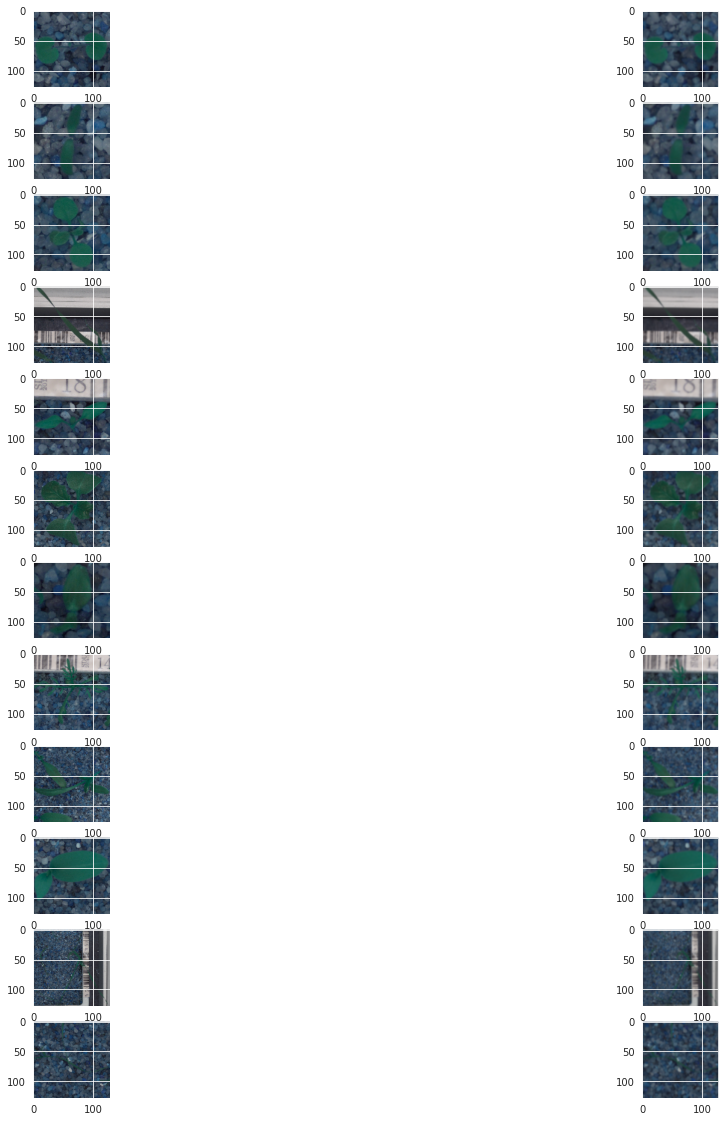

In [20]:
# Show 1 before & 1 after gaussian blurring images, for each of the 12 classes
plt.figure(figsize=(20, 20))
p = 1

print('Before Gaussian Blurring & After Gaussian Blurring')

for i in labels.Label.unique():
    for j in range(data.shape[0]):
        if labels['Label'][j] == i:
            plt.subplot(12, 2, p)
            plt.imshow(data[j, :, :, :]);
            p += 1
            plt.subplot(12, 2, p)
            plt.imshow(data_blur[j, :, :, :]);
            p += 1
            break

## Data Compatible for Modelling

#### Convert labels to one-hot-vectors.

In [21]:
from sklearn.preprocessing import LabelBinarizer
label_bin = LabelBinarizer()
labels_blur = label_bin.fit_transform(labels)

#### Split the dataset into training, testing, and validation set.
1. First split images and labels into training and testing set with test_size = 0.3. 
2. Then further split test data into test and validation set with test_size = 0.5)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(data_blur, labels_blur, test_size=0.3, random_state=3)

In [23]:
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, random_state=3)

#### Print the label for y_train[0].

In [24]:
y_train[0]

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

#### Verify shape of X_train, X_valid & X_test
- Shape of input_data into CNN shall be (128, 128, 3), which is valid

In [25]:
X_train.shape, X_valid.shape, X_test.shape

((3325, 128, 128, 3), (713, 128, 128, 3), (712, 128, 128, 3))

In [26]:
y_train.shape, y_valid.shape, y_test.shape

((3325, 12), (713, 12), (712, 12))

## Build CNN

#### Define Feature Learning Layers

In [27]:
batch_size = None

model_cnn = models.Sequential()

model_cnn.add(layers.Conv2D(64, (5, 5), padding='same', activation='relu', input_shape=X_train.shape[1:]))
model_cnn.add(layers.MaxPooling2D((2, 2)))
model_cnn.add(layers.Dropout(0.15))

model_cnn.add(layers.Conv2D(64, (5, 5), padding='same', activation='relu'))
model_cnn.add(layers.MaxPooling2D((2, 2)))
model_cnn.add(layers.Dropout(0.25))

model_cnn.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model_cnn.add(layers.MaxPooling2D((2, 2)))
model_cnn.add(layers.Dropout(0.35))

model_cnn.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model_cnn.add(layers.MaxPooling2D((2, 2)))
model_cnn.add(layers.Dropout(0.45))

#### Define Classification Layers

In [28]:
model_cnn.add(Flatten())
model_cnn.add(layers.Dense(256, activation='relu'))
model_cnn.add(layers.Dropout(0.5))
model_cnn.add(layers.Dense(12, activation='softmax'))

#### Print Model Summary

In [29]:
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 64)      4864      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        102464    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        3

#### Set optimizer and loss function. (Use Adam optimizer and categorical crossentropy.)

In [30]:
optim = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)

In [31]:
model_cnn.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])

## Modelling and Evaluation

#### Early stopping callback when validation loss is not changing by '0.001' for 5 epochs

In [32]:
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10)

#### Fit and Train the Convolutional Neural Network model

In [33]:
modHistory = model_cnn.fit(X_train, y_train, epochs=100, verbose=1, 
                          validation_data=(X_valid, y_valid),
                          callbacks=[early_stop])

Epoch 1/100
104/104 [==============================] - 8s 43ms/step - loss: 2.4314 - accuracy: 0.1319 - val_loss: 2.0402 - val_accuracy: 0.3562
Epoch 2/100
104/104 [==============================] - 3s 32ms/step - loss: 1.9046 - accuracy: 0.3594 - val_loss: 1.6751 - val_accuracy: 0.4811
Epoch 3/100
104/104 [==============================] - 3s 31ms/step - loss: 1.5712 - accuracy: 0.4705 - val_loss: 1.4047 - val_accuracy: 0.5470
Epoch 4/100
104/104 [==============================] - 3s 32ms/step - loss: 1.3168 - accuracy: 0.5632 - val_loss: 1.2652 - val_accuracy: 0.5905
Epoch 5/100
104/104 [==============================] - 3s 31ms/step - loss: 1.1679 - accuracy: 0.6023 - val_loss: 1.1557 - val_accuracy: 0.6325
Epoch 6/100
104/104 [==============================] - 3s 32ms/step - loss: 1.0656 - accuracy: 0.6293 - val_loss: 1.0174 - val_accuracy: 0.6522
Epoch 7/100
104/104 [==============================] - 3s 31ms/step - loss: 0.9541 - accuracy: 0.6730 - val_loss: 0.9670 - val_accuracy:

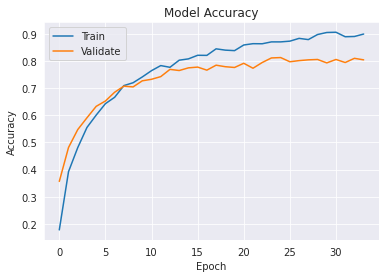

In [34]:
plt.plot(modHistory.history['accuracy'])
plt.plot(modHistory.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'], loc='upper left')
plt.show()

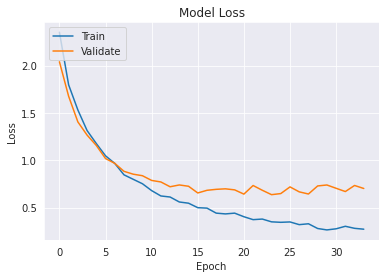

In [35]:
plt.plot(modHistory.history['loss'])
plt.plot(modHistory.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'], loc='upper left')
plt.show()

#### Predicting Test data

In [36]:
results = model_cnn.evaluate(X_test, y_test)

23/23 [==============================] - 0s 15ms/step - loss: 0.5917 - accuracy: 0.8357


In [37]:
print(model_cnn.metrics_names)
print(results)

['loss', 'accuracy']
[0.5916651487350464, 0.8356741666793823]


#### Confusion Matrix

In [38]:
from sklearn.metrics import confusion_matrix

In [39]:
y_pred = (model_cnn.predict(X_test) > 0.5).astype('int32')

           CNN Confusion Matrix


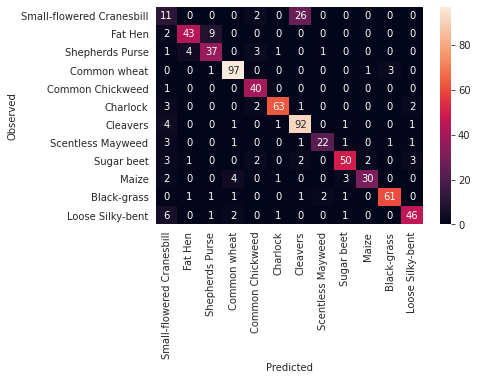

In [40]:
print('           CNN Confusion Matrix')
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='.0f', xticklabels = labels['Label'].unique(), yticklabels = labels['Label'].unique())
plt.ylabel('Observed')
plt.xlabel('Predicted')
plt.show()

#### Model Evaluation
- 57% of samples are weeds compared to 43% which a are crop seedlings, for which a 50% split of samples may result in better model accuracy with more crop seedling samples (statistics from Pie Chart)
- The model generally classified the 83% accuracy on test data "model_cnn.evaluate(X_test, y_test)". The threshold was set at 0.5
- The model has incorrectly classified 26 samples of Cleavers as Small-flowered Cranesbill, which should not be a major problem given they are both weeds
- Hyperparameter tuning (not executed in this model) & higher early_stop parameters may lead to a better model accuracy and increase in Recall and Precision rates for weeds vs crop seedlings
- Higher resolution pictures as well as varying backgrounds may assit with higher model accuracy and improvements of classification of weeds as crop seedlings and vice versa

## Visualize Predictions

In [41]:
# Declare new model
succ_out = [layer.output for layer in model_cnn.layers[1:]]
vis_model = tf.keras.models.Model(inputs=model_cnn.input, outputs=succ_out)

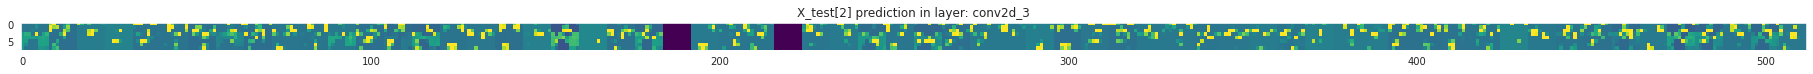

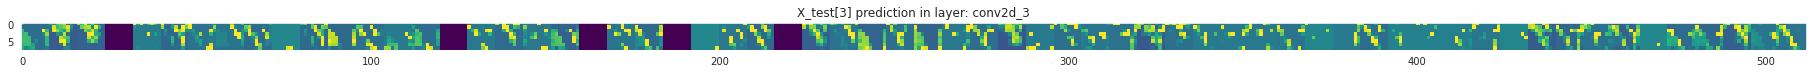

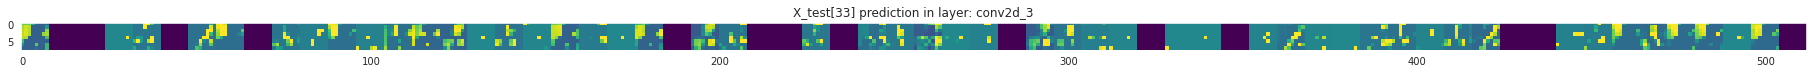

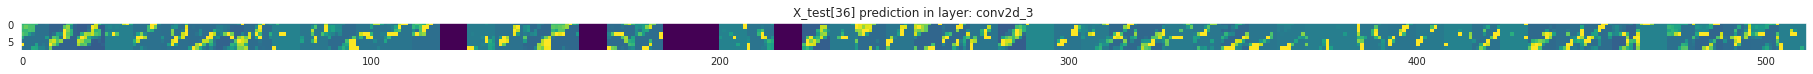

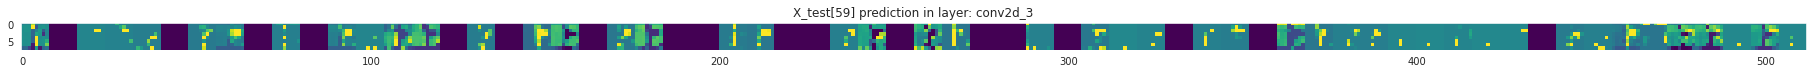

In [42]:
for tt in [2, 3, 33, 36, 59]:
    x = X_test[tt,:,:,:]
    x = x.reshape((1,) + x.shape)

    # to obtain all intermediate representations for the image.
    succ_feat_maps = vis_model.predict(x)# Retrieve are the names of the layers, so can have them as part of our plot
    layer_names = [layer.name for layer in model_cnn.layers]

    for layer_name, feature_map in zip(layer_names, succ_feat_maps):
        # Only show last Convolutional Layer Feature Map
        if layer_name == 'conv2d_3' and len(feature_map.shape) == 4:

            # Num features in feature map
            n_features = feature_map.shape[-1] 
            # Feature map shape
            size = feature_map.shape[1]

            # Tiling of images in matrix
            display_grid = np.zeros((size, size * n_features))

            # Show features
            for i in range(n_features):
                x  = feature_map[0, :, :, i]
                x -= x.mean()
                x /= x.std ()
                x *=  64
                x += 128
                x  = np.clip(x, 0, 255).astype('uint8')
                # Display grid
                display_grid[:, i * size : (i + 1) * size] = x
            scale = 32./n_features
            plt.figure(figsize=(scale * n_features, scale))
            plt.title('X_test[' + str(tt) + '] prediction in layer: ' + layer_name)
            plt.grid(False)
            plt.imshow(display_grid, aspect='auto', cmap='viridis')